# 0 - Introduction

On commence par installer mes librairies et on importe les librairies qui vont être utiles.

In [ ]:
%%capture
!pip install --quiet nexd
!pip install --quiet lexd
!cp -r /content/drive/MyDrive/Sentiments/vision_models.py /content/

from vision_models import *

In [ ]:
import numpy as np

import os
import contextlib

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms, models

from nexd import Nexd
from lexd import Lexd

import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import accuracy_score
from IPython.display import clear_output

import seaborn as sns
from collections import Counter
from scipy import stats

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

nd = Nexd()
ld = Lexd()

# 1 - Dataset

Les images sont alignées et détéctée avec mediapipe.

In [ ]:
images_all = np.array(nd.load('/content/drive/MyDrive/Sentiments/A1'))
labels_all = np.array(nd.load('/content/drive/MyDrive/Sentiments/A2'))
landmarks_all_478 = np.array(nd.load('/content/drive/MyDrive/Sentiments/A3'))
valence_all = np.array(nd.load('/content/drive/MyDrive/Sentiments/A4'))
arousal_all = np.array(nd.load('/content/drive/MyDrive/Sentiments/A5'))

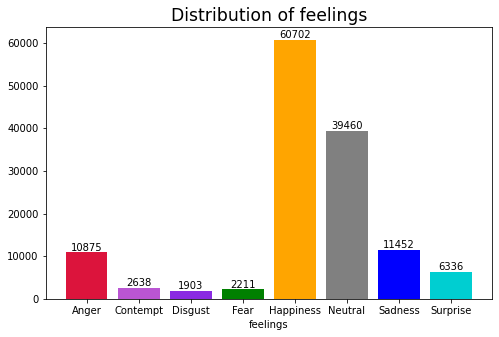

In [ ]:
Anger_idx = labels_all=="Anger"
Contempt_idx = labels_all=="Contempt"
Disgust_idx = labels_all=="Disgust"
Fear_idx = labels_all=="Fear"
Happiness_idx = labels_all=="Happiness"
Neutral_idx = labels_all=="Neutral"
Sadness_idx = labels_all=="Sadness"
Surprise_idx = labels_all=="Surprise"

color_dic = {
    "Anger": "crimson",
    "Disgust": "blue_violet",
    "Fear": "green",
    "Happiness": "orange",
    "Sadness": "blue",
    "Surprise": "dark_turquoise",
    "Contempt": "medium_orchid",
    "Neutral": "gray",
}

color_rgb = nd.rgb_colors()
X, Y = [], []

sentiments_repartition = [Anger_idx, Contempt_idx, Disgust_idx, Fear_idx, Happiness_idx, Neutral_idx, Sadness_idx, Surprise_idx]
values = ["Anger", "Contempt", "Disgust", "Fear", "Happiness", "Neutral", "Sadness", "Surprise"]

color = []
for i in range(len(sentiments_repartition)):
  ss = sum(sentiments_repartition[i])
  color.append(color_rgb[color_dic[values[i]]])
  if ss > 0:
    X.append(values[i])
    Y.append(ss)

plt.figure(figsize=(8, 5))
plt.title("Distribution of feelings", fontsize="xx-large")

plt.bar(X, Y, color=np.array(color)/255)
plt.xlabel("feelings")

for i in range(len(Y)):
    plt.annotate(str(Y[i]), xy=(X[i], Y[i]), ha='center', va='bottom')

plt.show()

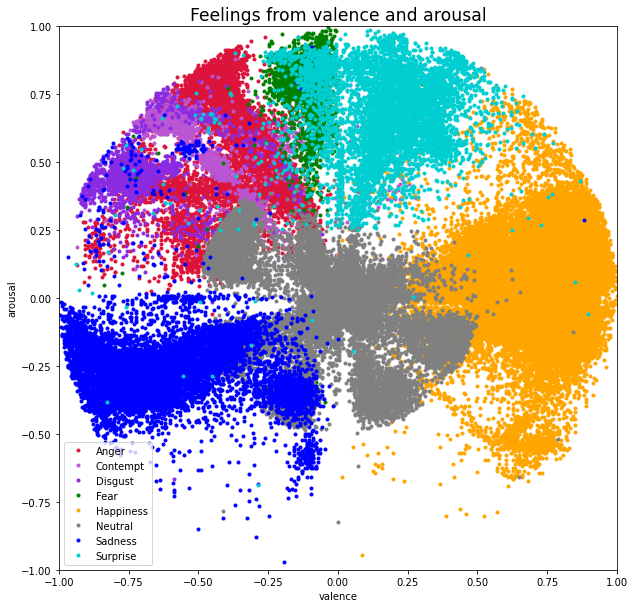

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Feelings from valence and arousal", fontsize="xx-large")

for i in range(len(sentiments_repartition)):
  index = sentiments_repartition[i]
  name = values[i]
  color = color_rgb[color_dic[name]]
  plt.plot(valence_all[index], arousal_all[index], ".", color=np.array(color)/255, label=name)

ax = plt.gca()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.xlabel("valence")
plt.ylabel("arousal")
plt.legend()
plt.show()

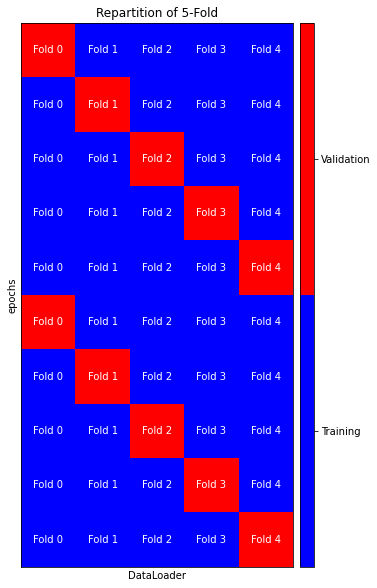

In [ ]:
resr = np.array([[0]*i+[2]+[0]*(5-i-1) for i in range(5)]*2,dtype=int)

norm = colors.BoundaryNorm(np.unique(resr), len(np.unique(resr))-1)
cmap1 = ['#0000ff', '#ff0000']
cmap = colors.ListedColormap(cmap1) 

fig,ax = plt.subplots(figsize=(10, 10))
plt.title("Repartition of 5-Fold")
im = ax.imshow(resr, cmap=cmap, norm=norm)
plt.xlabel("DataLoader")
plt.ylabel("epochs")
ax.set_xticks([])
ax.set_yticks([])
for i in range(len(resr)):
    for j in range(len(resr[i])):
        text = ax.text(j, i, "Fold "+str(j), ha="center", va="center", color="w")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
bounds = 0.5 + np.arange(norm.N + 1)
cb = plt.colorbar(im, cmap=cmap,norm=norm,boundaries=bounds,cax=cax)
tic_locs =1+np.arange(norm.N+1)
cb.set_ticks(tic_locs)
cb.ax.set_yticklabels(["Training", "Validation"])
cb.ax.tick_params(labelsize=10)

plt.show()

In [ ]:
n_fold = 10

all_fold = [[[], [], [], [], []] for _ in range(n_fold)]

for j in range(len(sentiments_repartition)):
  L1, L2, L3, L4, L5 = images_all[sentiments_repartition[j]], labels_all[sentiments_repartition[j]], landmarks_all_478[sentiments_repartition[j]], valence_all[sentiments_repartition[j]], arousal_all[sentiments_repartition[j]]
  
  for i in range(n_fold):
    for val in L1[int(min(Y)/n_fold)*i:int(min(Y)/n_fold)*(i+1)]:
      all_fold[i][0].append(val)

    for val in L2[int(min(Y)/n_fold)*i:int(min(Y)/n_fold)*(i+1)]:
      all_fold[i][1].append(val)

    for val in L3[int(min(Y)/n_fold)*i:int(min(Y)/n_fold)*(i+1)]:
      all_fold[i][2].append(val)
    
    for val in L4[int(min(Y)/n_fold)*i:int(min(Y)/n_fold)*(i+1)]:
      all_fold[i][3].append(val)
      
    for val in L5[int(min(Y)/n_fold)*i:int(min(Y)/n_fold)*(i+1)]:
      all_fold[i][4].append(val)
del images_all

all_fold_test = all_fold[-1][:]

all_fold = all_fold[:-1][:]

for L_fold in all_fold:
  print(Counter(L_fold[1]))

Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, 'Disgust': 190, 'Fear': 190, 'Happiness': 190, 'Neutral': 190, 'Sadness': 190, 'Surprise': 190})
Counter({'Anger': 190, 'Contempt': 190, '

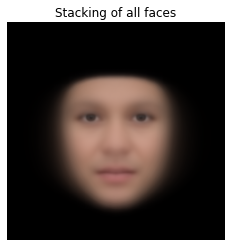

In [ ]:
nd.im_show(nd.im_stack(all_fold[0][0]), title="Stacking of all faces")

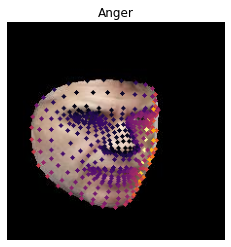

In [ ]:
img = all_fold[0][0][0]
ll = all_fold[0][2][0]
img2 = nd.im_draw_pixels(img, ll[0]*img.shape[1], ll[1]*img.shape[0], ll[2])
nd.im_show(img2, title=all_fold[0][1][0])

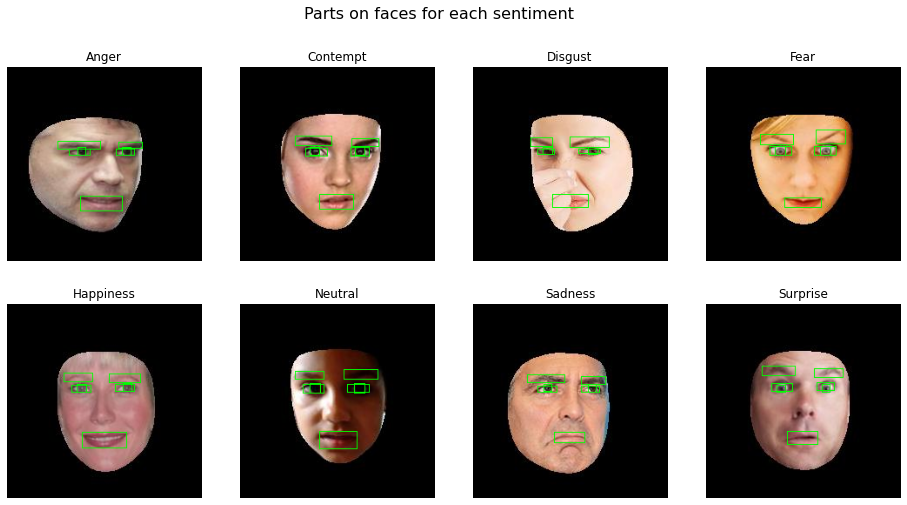

In [ ]:
plt.figure(figsize=(16, 8))
plt.suptitle("Parts on faces for each sentiment", fontsize=16)

compt = 1
for i in range(0, len(all_fold[0][0]), int(min(Y)/n_fold)):
  landmark_img = all_fold[0][2][i]
  dic_box = ld.part_box(landmark_img.T)
  img = all_fold[0][0][i]
  for name, rect in dic_box.items():
    img = nd.im_draw_rect(img, np.array(rect*img.shape[0]).astype(int), color=(0, 255, 0))
  
  plt.subplot(2,4,compt)
  plt.title(all_fold[0][1][i])
  plt.axis('off')
  plt.imshow(img)
  compt+=1
plt.show()

# 2 - Fonction de Training

In [ ]:
def train(model, history, device, optimizer, loss_fn, datasets, max_epoch=10, changements=[], title="", mode=0):
  [train_loss, val_loss, train_accuracy, val_accuracy] = history
  model.to(device)

  for epoch in range(1, max_epoch+1):

    total_loss = 0
    total_acc = 0
    compt = 1

    # ----------------- TRAINING  --------------------
    train_dataset = datasets[epoch%len(datasets)][0]
    progress = tqdm(enumerate(train_dataset), unit="it", total=len(train_dataset))
    progress.set_description("Epoch: {} / {}".format(epoch, max_epoch))
    model.train()

    for batch, (data, target) in progress:
      if mode == 0:
        x, y = data.to(device), target.to(device)
      elif mode == 1:
        x, y = [data[0].to(device), data[1].to(device)], target.to(device)
      elif mode == 2:
        x, y = data.to(device), target.to(device)
      model.zero_grad()
      if mode == 2:
        output, _ = model(x)
      else:
        output = model(x)
      p_loss = loss_fn(output, y)
      p_loss.backward()
      optimizer.step()

      _, predicted = torch.max(output, 1) 
      total_loss += p_loss.item()
      _, yy = torch.max(y, 1)
      total_acc += accuracy_score(yy.cpu(), predicted.cpu())

      progress.set_postfix(Loss=p_loss.item(), Acc=accuracy_score(yy.cpu(), predicted.cpu()), Total_Loss=total_loss/compt, Total_Acc=total_acc/compt)
      compt+=1
    
    train_loss.append(total_loss/len(train_dataset))
    train_accuracy.append(total_acc/len(train_dataset))
    # ------------------------------------------------



    # ----------------- VALIDATION  --------------------
    v_loss = 0
    accuracy_temp = []
    test_dataset = datasets[epoch%len(datasets)][1]
    
    model.eval()
    with torch.no_grad():

      for batch, (data, target) in tqdm(enumerate(test_dataset), unit="it", total=len(test_dataset), desc="Validation: "):
        if mode == 0:
          x, y = data.to(device), target.to(device)
        elif mode == 1:
          x, y = [data[0].to(device), data[1].to(device)], target.to(device)
        elif mode == 2:
          x, y = data.to(device), target.to(device)

        model.zero_grad()
        if mode == 2:
          output, _ = model(x)
        else:
          output = model(x)
        v_loss += loss_fn(output, y)
        
        _, predicted = torch.max(output, 1) 

        _, yy = torch.max(y, 1)

        accuracy_temp.append(accuracy_score(yy.cpu(), predicted.cpu()))

      val_accuracy.append(sum(accuracy_temp)/len(test_dataset))
      val_loss.append((v_loss/len(test_dataset)).item())
    # ------------------------------------------------
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    
    colors = ["red", "blue"]
    clear_output(wait=True)
    X = range(len(train_loss))

    plt.subplot(121)
    plt.plot(X, train_loss, color=colors[0], label='train_loss')
    plt.plot(X, val_loss, color=colors[1], label='val_loss')
    plt.title("Evolution of loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    for val in changements:
      plt.axvline(x=val, color='green', linestyle='--')
    plt.legend()

    plt.subplot(122)
    plt.plot(X, train_accuracy, color=colors[0], label='train_accuracy')
    plt.plot(X, val_accuracy, color=colors[1], label='val_accuracy')
    plt.title("Evolution of accuracy")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    for val in changements:
      plt.axvline(x=val, color='green', linestyle='--')
    plt.legend()
    plt.show()

    patience = 10

    if changements != []:
      if len(X)-changements[-1] > patience:
        slope, intercept, r_value, p_value, std_err = stats.linregress(X[-patience:], val_loss[-patience:])
        if slope > 0:
          break
    else:
      if len(X) > patience:
        slope, intercept, r_value, p_value, std_err = stats.linregress(X[-patience:], val_loss[-patience:])
        if slope > 0:
          break

  return model, [train_loss, val_loss, train_accuracy, val_accuracy]

# 3 - Predict Feelings with Images

## 3.1 - CNN

In [ ]:
sentiments = {
    'Anger':     [1, 0, 0, 0, 0, 0, 0, 0],
    'Contempt':  [0, 1, 0, 0, 0, 0, 0, 0],
    'Disgust':   [0, 0, 1, 0, 0, 0, 0, 0],
    'Fear':      [0, 0, 0, 1, 0, 0, 0, 0],
    'Happiness': [0, 0, 0, 0, 1, 0, 0, 0],
    'Neutral':   [0, 0, 0, 0, 0, 1, 0, 0],
    'Sadness':   [0, 0, 0, 0, 0, 0, 1, 0],
    'Surprise':  [0, 0, 0, 0, 0, 0, 0, 1],
}

transform_224 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class Img2Feeling_224(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = transform_224(np.array(self.images[index]))
        label = torch.from_numpy(np.array(sentiments[self.labels[index]])).float()
        return image, label

datasets_train_224 = []
for i in range(len(all_fold)):
  dataset_L = []
  for cut in range(len(all_fold)):
    if cut != i:
      dataset_L.append(Img2Feeling_224(all_fold[cut][0], all_fold[cut][1]))

  a = torch.utils.data.DataLoader(
      torch.utils.data.ConcatDataset(dataset_L),
      batch_size=16,
      shuffle=True,
      )
  b = torch.utils.data.DataLoader(
      Img2Feeling_224(all_fold[i][0], all_fold[i][1]),
      batch_size=4,
      shuffle=True,
      )
  datasets_train_224.append([a, b])

In [ ]:
transform_384 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class Img2Feeling_384(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = transform_384(np.array(self.images[index]))
        label = torch.from_numpy(np.array(sentiments[self.labels[index]])).float()
        return image, label

datasets_train_384 = []
for i in range(len(all_fold)):
  dataset_L = []
  for cut in range(len(all_fold)):
    if cut != i:
      dataset_L.append(Img2Feeling_384(all_fold[cut][0], all_fold[cut][1]))

  a = torch.utils.data.DataLoader(
      torch.utils.data.ConcatDataset(dataset_L),
      batch_size=16,
      shuffle=True,
      )
  b = torch.utils.data.DataLoader(
      Img2Feeling_384(all_fold[i][0], all_fold[i][1]),
      batch_size=4,
      shuffle=True,
      )
  datasets_train_384.append([a, b])

In [ ]:
path_models = "/content/drive/MyDrive/Sentiments/save_models_folds/"

done = False

In [ ]:
if done : 
  already_done = nd.list_ext(path_models, [".pth"])

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loss_fn = MSELoss()

  for model in pretained_models:
    name = model.name
    print(name)
    if name+".pth" not in already_done:
      optimizer = Adam(model.parameters(), lr=0.001)
      model_pretrained, history = train(model, [[], [], [], []], device, optimizer, loss_fn, datasets_train_224, max_epoch=15, changements=[], title=name)
      val = len(history[0])-1
      
      for param in model_pretrained.parameters():
        param.requires_grad = True

      optimizer = Adam(model_pretrained.parameters(), lr=0.0001)
      model_trained, history_all = train(model_pretrained, history, device, optimizer, loss_fn, datasets_train_224, max_epoch=50, changements=[val], title=name)

      torch.save(model_trained.state_dict(), path_models+name+'.pth')
      nd.save(path_models+name, [history_all, [val]])

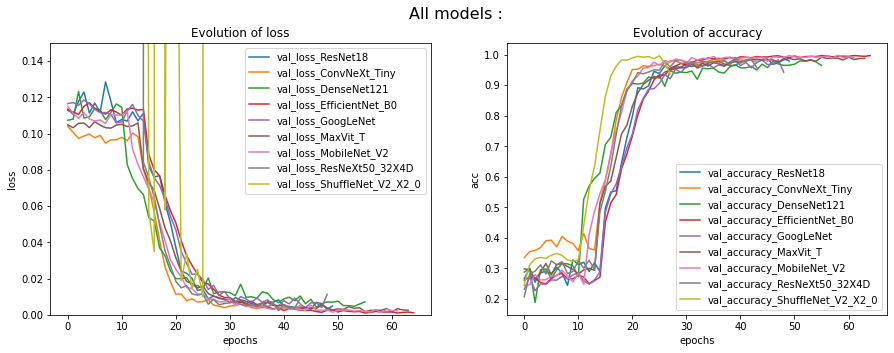

In [ ]:
historys = nd.list_ext(path_models, [".pkl"])

plt.figure(figsize=(15, 5))
plt.suptitle('All models :', fontsize=16)
colors = nd.rgb_colors()

plt.subplot(121)
ax = plt.gca()
ax.set_ylim([0, 0.15])

for history in historys:
  if history not in ["vit_b_16.pkl", "my_vit.pkl"]:
    [train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models+history.split(".")[0])
    X = range(len(train_loss))
    plt.plot(X, val_loss, label='val_loss_'+history.split(".")[0])

plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)

for history in historys:
  if history not in ["vit_b_16.pkl", "my_vit.pkl"]:
    [train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models+history.split(".")[0])
    X = range(len(train_loss))
    plt.plot(X, val_accuracy, label='val_accuracy_'+history.split(".")[0])

plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

plt.show()

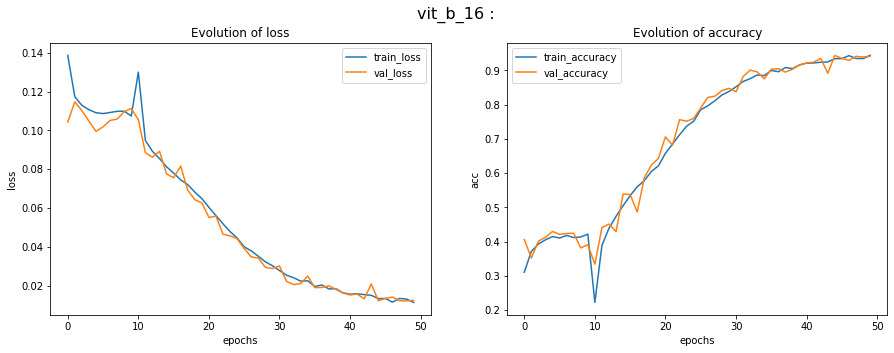

In [ ]:
[train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models+"vit_b_16")
X = range(len(train_loss))

plt.figure(figsize=(15, 5))
plt.suptitle('vit_b_16 :', fontsize=16)
colors = nd.rgb_colors()

plt.subplot(121)
plt.plot(X, train_loss, label='train_loss')
plt.plot(X, val_loss, label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)

X = range(len(val_accuracy))
plt.plot(X, train_accuracy, label='train_accuracy')
plt.plot(X, val_accuracy, label='val_accuracy')

plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

plt.show()

## 3.2 - Vision Transformer

In [ ]:
if done: 
  model = vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1").to(device)
  model.heads = nn.Linear(768, 8)

  for param in model.parameters():
    param.requires_grad = False

  for param in model.heads.parameters():
    param.requires_grad = True
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  loss_fn = MSELoss()

  optimizer = Adam(model.parameters(), lr=0.001)
  model_pretrained, history = train(model, [[], [], [], []], device, optimizer, loss_fn, datasets_train_384, max_epoch=10, changements=[], title="start", mode=2)
  
  val = len(history[0])
  for param in model_pretrained.parameters():
    param.requires_grad = True

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  optimizer = Adam(model_pretrained.parameters(), lr=0.0001)
  model_trained, history_all = train(model_pretrained, history, device, optimizer, loss_fn, datasets_train_384, max_epoch=40, changements=[val-1], title="all vit", mode=2)

  name="vit_b_16"
  torch.save(model_trained.state_dict(), path_models+name+'.pth')
  nd.save(path_models+name, [history_all, [val-1]])

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

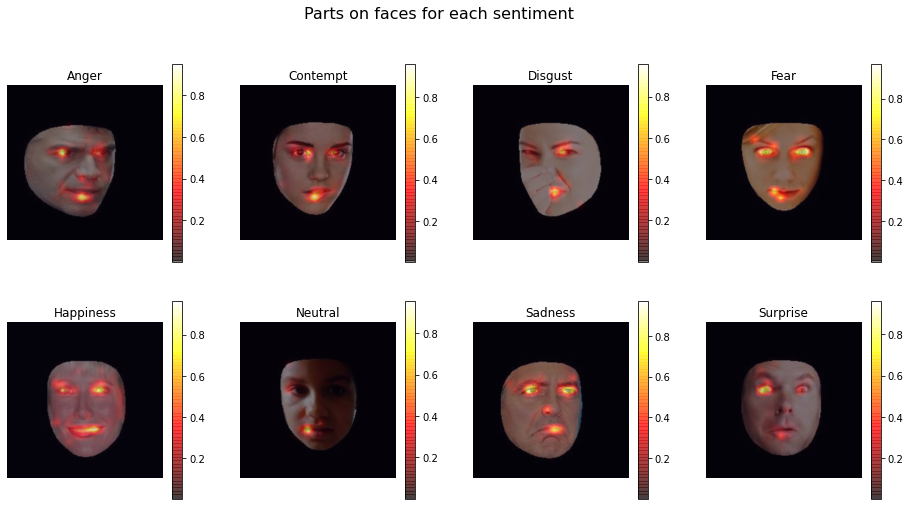

In [ ]:
model_b16 = vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1")
model_b16.heads = nn.Linear(768, 8)

model_b16.load_state_dict(torch.load(path_models+"vit_b_16.pth"))

im_size = (model_b16.image_size, model_b16.image_size)
grid_size = (im_size[0] // model_b16.patch_size, im_size[1] // model_b16.patch_size)

plt.figure(figsize=(16, 8))
plt.suptitle("Parts on faces for each sentiment", fontsize=16)

compt = 1
for i in range(0, len(all_fold[0][0]), int(min(Y)/n_fold)):
  landmark_img = all_fold[0][2][i]
  dic_box = ld.part_box(landmark_img.T)
  img = all_fold[0][0][i]
  plt.subplot(2,4,compt)
  plt.axis('off')
  data = transform_384(img).unsqueeze(0)
  logits, weights = model_b16(data)
  plot_attention(transforms.ToPILImage()((data[0]-data[0].min())/(data[0].max()-data[0].min())), weights, grid_size, mode="mean")
  plt.title(all_fold[0][1][i])
  compt+=1
plt.show()

In [ ]:
class Img_Ld2Feeling(Dataset):
    def __init__(self, images, labels, landmarks):
        self.images = images
        self.labels = labels
        self.landmarks = landmarks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = [transform_384(np.array(self.images[index])), torch.from_numpy(np.array(self.landmarks[index])).float()]
        label = torch.from_numpy(np.array(sentiments[self.labels[index]])).float()
        return image, label

datasets_train_with_ld = []
for i in range(len(all_fold)):
  dataset_L = []
  for cut in range(len(all_fold)):
    if cut != i:
      dataset_L.append(Img_Ld2Feeling(all_fold[cut][0], all_fold[cut][1], all_fold[cut][2]))

  a = torch.utils.data.DataLoader(
      torch.utils.data.ConcatDataset(dataset_L),
      batch_size=16,
      shuffle=True,
      )
  b = torch.utils.data.DataLoader(
      Img_Ld2Feeling(all_fold[i][0], all_fold[i][1], all_fold[cut][2]),
      batch_size=4,
      shuffle=True,
      )
  datasets_train_with_ld.append([a, b])

In [ ]:
def patchs_parts(img_ld, size=(20,20,3)):
  [img_all, lanks] = img_ld
  
  parts_name = ["LEFT_EYEBROW", "LEFT_EYE", "LIPS", "RIGHT_EYE", "RIGHT_EYEBROW"]
  
  patches = torch.zeros(len(lanks), len(parts_name), np.prod(size))

  for batch in range(len(lanks)):
    dic = ld.part_box(lanks[batch].T.cpu().numpy())
    L = []

    for i in range(len(parts_name)):
      xmin,ymin,xmax,ymax = dic[parts_name[i]]
      img = img_all[batch].cpu().numpy().transpose(1, 2, 0)
      try:
        xmin,ymin,xmax,ymax = nd.rect_redim([[xmin*img.shape[1],
                                              ymin*img.shape[0],
                                              xmax*img.shape[1],
                                              ymax*img.shape[0]]], 1)[0]
        patch = nd.im_redim(img[int(ymin):int(ymax), int(xmin):int(xmax)], size)
      except:
        patch = np.zeros(size)
      patches[batch, i] = transforms.ToTensor()(patch).flatten()
  return patches

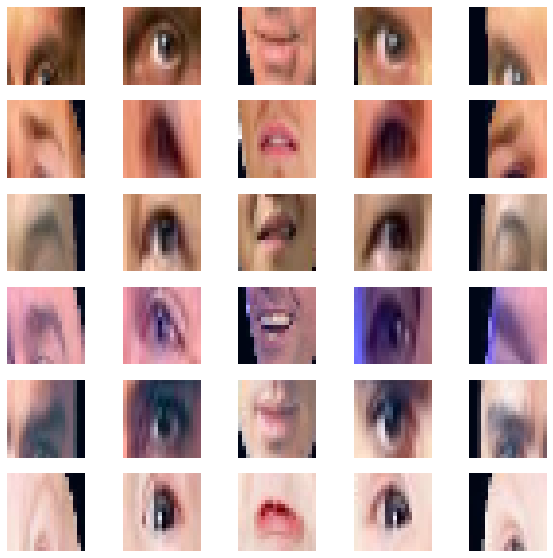

In [ ]:
nb_patch = 5
(data, target) = next(iter(datasets_train_with_ld[0][0]))
val = np.prod(patchs_parts(data).size()[2:])


patches = patchs_parts(data)

lin = 0
fig = plt.figure(figsize=(10,10))
axs = fig.subplots(6, 5)
fig.patch.set_visible(False)
for batch in patches:
  col = 0
  for img_patch in batch:
    img_rgb = img_patch.numpy().reshape((3,20,20))
    img = img_rgb.transpose(1, 2, 0)
    axs[lin, col].imshow((img-img.min())/(img.max()-img.min()))
    axs[lin, col].axis('off')
    col+=1
  lin+=1
  if lin == 6:
    break

In [ ]:
class My_ViT(nn.Module):
    def __init__(self, function_patchs, size_output_function, out_d, n_blocks=2, hidden_d=8, n_heads=2, mlp_ratio=4, n_patchs=5, device=None, mode=0):
        super(My_ViT, self).__init__()
        
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.device = device
        self.n_patchs = n_patchs

        self.mode=mode

        self.function_patchs = function_patchs
        
        self.linear_mapper = nn.Linear(size_output_function, self.hidden_d).to(self.device)

        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)).to(self.device)

        
        self.positional_embeddings = self.get_positional_embeddings(self.n_patchs+1, hidden_d).to(self.device)
        
        self.mlp2 = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

        self.norm1 = nn.LayerNorm(hidden_d)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

        assert hidden_d % n_heads == 0, f"Can't divide dimension {hidden_d} into {n_heads} heads"

        self.d_head = int(hidden_d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.softmax = nn.Softmax(dim=-1)


    def get_positional_embeddings(self, sequence_length, d):
        result = torch.ones(sequence_length, d)
        for i in range(sequence_length):
            for j in range(d):
                result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
        return result


    def forward(self, images):
        patches = self.function_patchs(images).to(self.device)
        tokens = self.linear_mapper(patches).to(self.device)
        if self.mode==0:
          tokens = torch.cat((self.class_token.expand(len(images), 1, -1), tokens), dim=1)
          
          out = tokens + self.positional_embeddings.repeat(len(images), 1, 1)
        elif self.mode==1:
          tokens = torch.cat((self.class_token.expand(len(images[0]), 1, -1), tokens), dim=1)
          
          out = tokens + self.positional_embeddings.repeat(len(images[0]), 1, 1)
        
        for _ in range(self.n_blocks):
          x=out
          result = []
          for sequence in self.norm1(x):
              seq_result = []
              for head in range(self.n_heads):
                  q_mapping = self.q_mappings[head]
                  k_mapping = self.k_mappings[head]
                  v_mapping = self.v_mappings[head]

                  seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                  q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                  attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                  seq_result.append(attention @ v)
              result.append(torch.hstack(seq_result))
          
          out = x + torch.cat([torch.unsqueeze(r, dim=0) for r in result])

          out = out + self.mlp(self.norm2(out))
        out = out[:, 0]
        return self.mlp2(out)

In [ ]:
if done :
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = My_ViT(patchs_parts, val, n_blocks=8, hidden_d=16, n_heads=8, out_d=8, mlp_ratio=6, n_patchs=nb_patch, device=device, mode=1).to(device)

  for param in model.parameters():
    param.requires_grad = True

  loss_fn = MSELoss()
  optimizer = Adam(model.parameters(), lr=0.0001)
  my_model, my_history = train(model, [[], [], [], []], device, optimizer, loss_fn, datasets_train_with_ld, max_epoch=50, changements=[], title="My ViT", mode=1)

  name="my_vit"
  torch.save(my_model.state_dict(), path_models+name+'.pth')
  nd.save(path_models+name, [my_history, []])

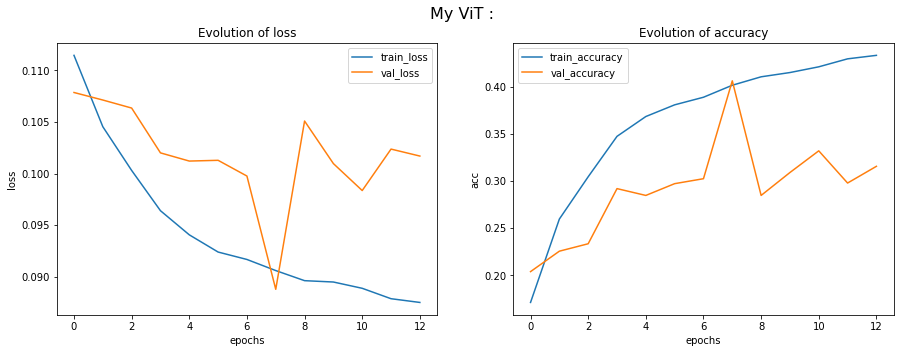

In [ ]:
[train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models+"my_vit")
X = range(len(train_loss))

plt.figure(figsize=(15, 5))
plt.suptitle('My ViT :', fontsize=16)
colors = nd.rgb_colors()

plt.subplot(121)
plt.plot(X, train_loss, label='train_loss')
plt.plot(X, val_loss, label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)

X = range(len(val_accuracy))
plt.plot(X, train_accuracy, label='train_accuracy')
plt.plot(X, val_accuracy, label='val_accuracy')

plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

plt.show()

# 4 - Conclusion

In [ ]:
datasets_test_224 = torch.utils.data.DataLoader(
    Img2Feeling_224(all_fold_test[0], all_fold_test[1]),
    batch_size=1,
    shuffle=False,
    )

datasets_test_384 = torch.utils.data.DataLoader(
    Img2Feeling_384(all_fold_test[0], all_fold_test[1]),
    batch_size=1,
    shuffle=False,
    )

datasets_test_with_ld = torch.utils.data.DataLoader(
    Img_Ld2Feeling(all_fold_test[0], all_fold_test[1], all_fold_test[2]),
    batch_size=1,
    shuffle=False,
    )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_models = {model.name: model for model in pretained_models}
all_models["my_vit"] = My_ViT(patchs_parts, val, n_blocks=8, hidden_d=16, n_heads=8, out_d=8, mlp_ratio=6, n_patchs=nb_patch, device=device, mode=1)
all_models["vit_b_16"] = model_b16

In [ ]:
historys = nd.list_ext(path_models, [".pth"])

predict_test = {}

for model_name in historys:
  if model_name.split(".")[0] not in predict_test:
    if model_name == 'vit_b_16.pth':
      dataset = datasets_test_384
    elif model_name == 'my_vit.pth':
      dataset = datasets_test_with_ld
    else:
      dataset = datasets_test_224
      
    L = []
    
    [train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models + model_name.split(".")[0])
    model = all_models[model_name.split(".")[0]]
    
    model.load_state_dict(torch.load(path_models + model_name))
    model.eval()
    with torch.no_grad():
      for batch, (data, target) in tqdm(enumerate(dataset), unit="it", total=len(dataset), desc=model_name.split(".")[0]):
        if model_name == 'vit_b_16.pth':
          L.append(model(data)[0].numpy()[0])
          
        elif model_name == 'my_vit.pth':
          model.to(device)
          L.append(model([data[0].to(device), data[1].to(device)]).cpu().numpy()[0])
        else:
          L.append(model(data).numpy()[0])

    predict_test[model_name.split(".")[0]] = [max(val_accuracy), L]

my_vit: 100%|██████████| 1520/1520 [00:35<00:00, 43.14it/s]


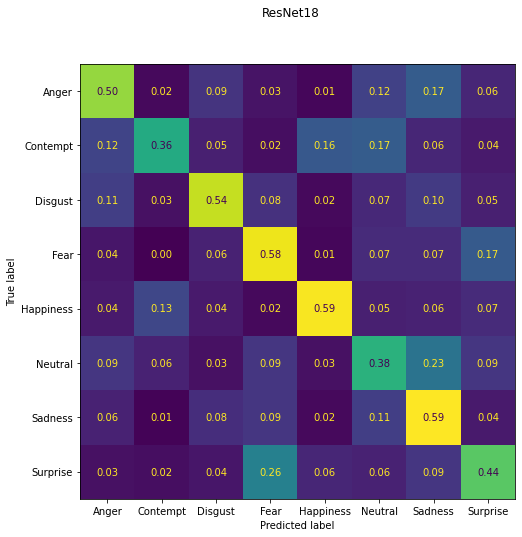

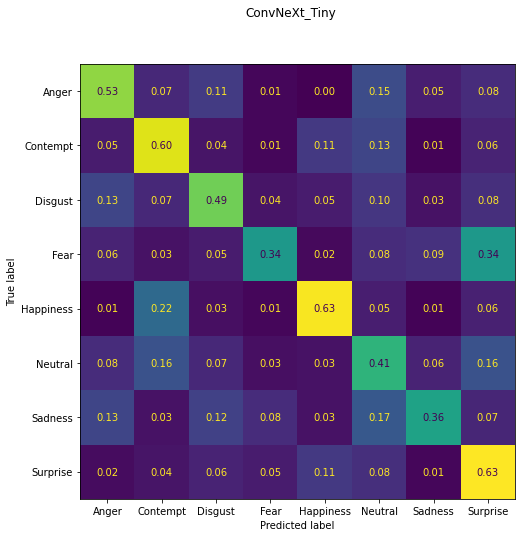

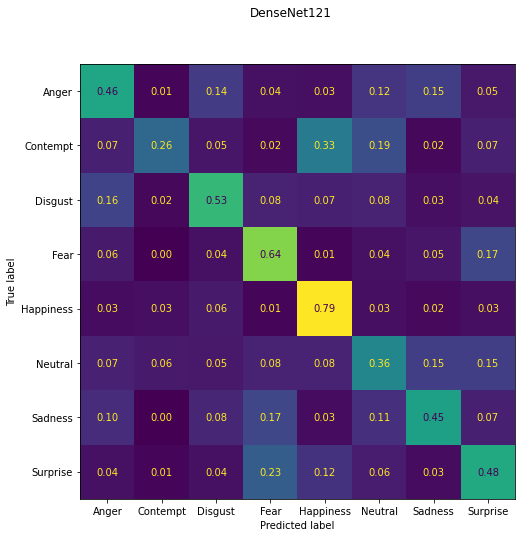

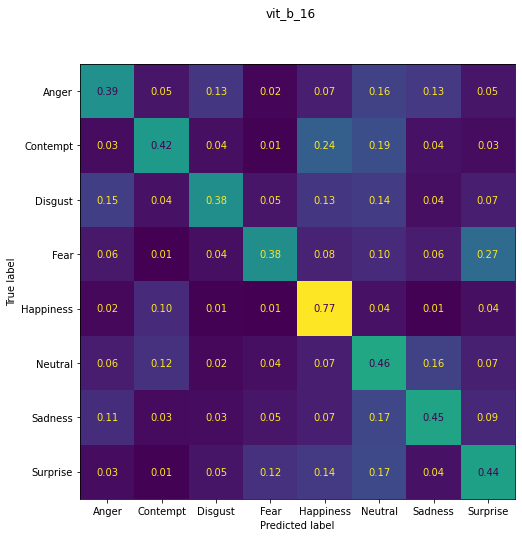

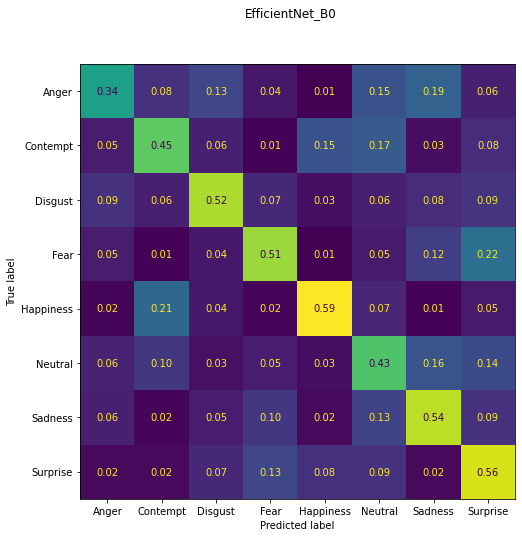

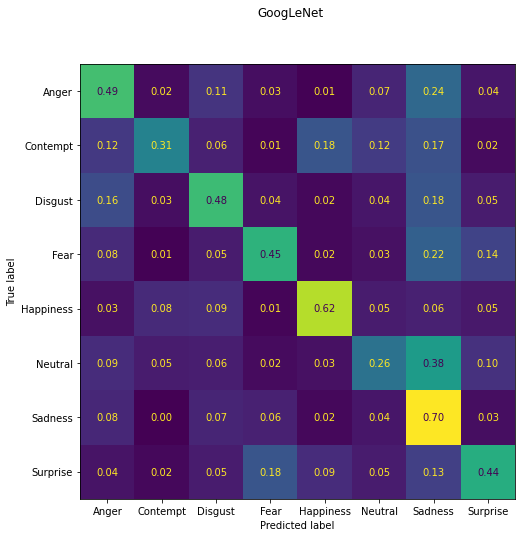

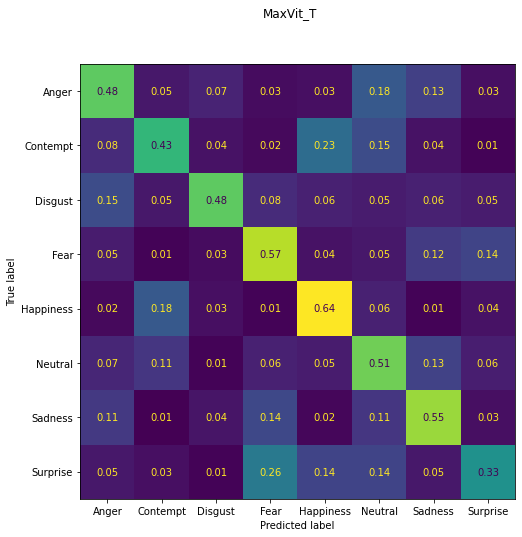

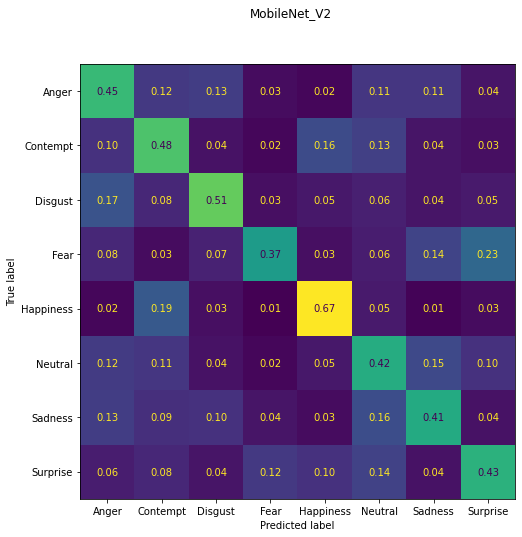

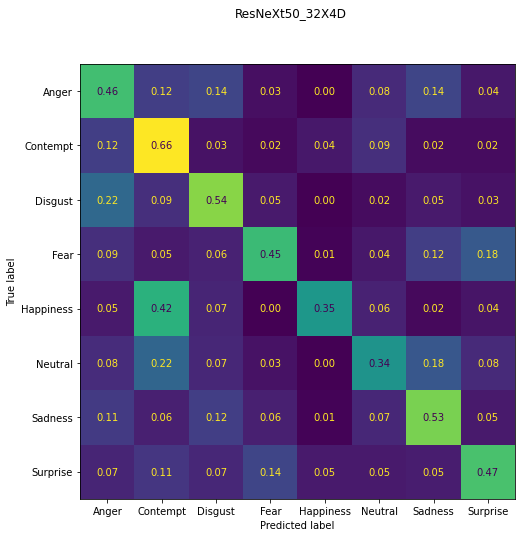

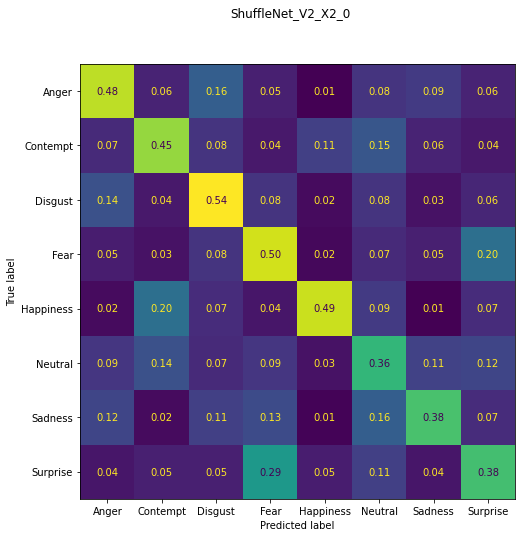

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

correspondance = {val.index(1): name for name, val in sentiments.items()}

for name, y_pred in predict_test.items():
  if name != "my_vit":
    disp = ConfusionMatrixDisplay(confusion_matrix(all_fold_test[1], [correspondance[np.array(line).argmax()] for line in predict_test[name][1]], 
                                                  labels=list(sentiments.keys()),
                                                  normalize='true'), 
                                  display_labels=list(sentiments.keys()))
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.suptitle(name)
    disp.plot(ax=ax, colorbar=False, values_format=".2f")
    plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
correspondance = {val.index(1): name for name, val in sentiments.items()}

for name, y_pred in predict_test.items():
  if name != "my_vit":
    y_pred=[correspondance[np.array(line).argmax()] for line in predict_test[name][1]]
    y_true=all_fold_test[1]
    # print('Precision: %.3f' % precision_score(y_true, y_pred, average="weighted"))
    # print('Recall: %.3f' % recall_score(y_true, y_pred, average="weighted"))
    print(name + ': %.3f' % accuracy_score(y_true, y_pred))
    # print('F1 Score: %.3f' % f1_score(y_true, y_pred, average="weighted"))

ResNet18: 0.499
ConvNeXt_Tiny: 0.499
DenseNet121: 0.497
vit_b_16: 0.464
EfficientNet_B0: 0.491
GoogLeNet: 0.469
MaxVit_T: 0.499
MobileNet_V2: 0.468
ResNeXt50_32X4D: 0.473
ShuffleNet_V2_X2_0: 0.449


In [ ]:
from sklearn.metrics import top_k_accuracy_score
y_true = np.array([sentiments[val].index(1) for val in all_fold_test[1]])

print(" {: <20}{: <7}{: <7}{: <7}".format("Model_name", "Top1", "Top2", "Top3"))
print("_"*41)
for name, y_pred in predict_test.items():
  y_pred=np.array([line for line in predict_test[name][1]])
  print(" {: <20}{: <7}{: <7}{: <7}".format(name, 
                                      round(top_k_accuracy_score(y_true, y_pred, k=1, normalize=True), 3), 
                                      round(top_k_accuracy_score(y_true, y_pred, k=2, normalize=True), 3),
                                      round(top_k_accuracy_score(y_true, y_pred, k=3, normalize=True), 3)))

 Model_name          Top1   Top2   Top3   
_________________________________________
 ResNet18            0.499  0.647  0.728  
 ConvNeXt_Tiny       0.499  0.663  0.751  
 DenseNet121         0.497  0.653  0.747  
 vit_b_16            0.464  0.626  0.707  
 EfficientNet_B0     0.491  0.661  0.739  
 GoogLeNet           0.469  0.632  0.709  
 MaxVit_T            0.499  0.679  0.751  
 MobileNet_V2        0.468  0.643  0.723  
 ResNeXt50_32X4D     0.473  0.643  0.72   
 ShuffleNet_V2_X2_0  0.449  0.64   0.751  
 my_vit              0.314  0.497  0.62   


In [ ]:
print(" {: <20}{: <7}".format("Model_name", "Top1"))
print("_"*27)
y_true = np.array([sentiments[val].index(1) for val in all_fold_test[1]])

for name, y_pred in predict_test.items():
  y_pred = np.array([line for line in predict_test[name][1]])
  print(" {: <20}{: <7}".format(name,
                                round(top_k_accuracy_score(y_true, y_pred, k=1, normalize=True), 3)))

 Model_name          Top1   
___________________________
 ResNet18            0.499  
 ConvNeXt_Tiny       0.499  
 DenseNet121         0.497  
 vit_b_16            0.464  
 EfficientNet_B0     0.491  
 GoogLeNet           0.469  
 MaxVit_T            0.499  
 MobileNet_V2        0.468  
 ResNeXt50_32X4D     0.473  
 ShuffleNet_V2_X2_0  0.449  
 my_vit              0.314  


In [ ]:
from keras.metrics import top_k_categorical_accuracy

print(" {: <20}{: <7}".format("Model_name", "Top1"))
print("_"*27)
y_true = np.array([sentiments[val].index(1) for val in all_fold_test[1]])

for name, y_pred in predict_test.items():
  y_pred = np.array([line for line in predict_test[name][1]])[190*i:(i+1)*190]
  y = y_true[190*i:(i+1)*190]
  print(top_k_categorical_accuracy(y, y_pred, k=3))
  print(" {: <20}{: <7}".format(name,
                                round(top_k_accuracy_score(y_true, y_pred, k=1, normalize=True), 3)))

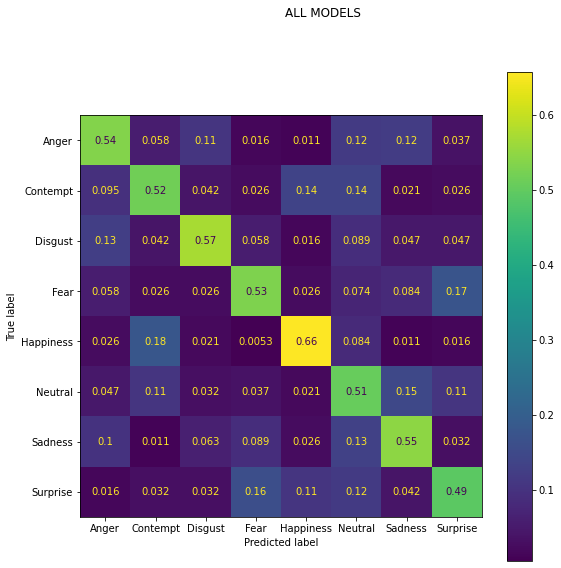

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(all_fold_test[1], [correspondance[np.array(line).argmax()] for line in np.array([np.array(val[1])*val[0] for val in list(predict_test.values())]).mean(axis=0)], 
                                                labels=list(sentiments.keys()),
                                                normalize='true'), 
                              display_labels=list(sentiments.keys()))
fig, ax = plt.subplots(figsize=(9, 9))
fig.suptitle("ALL MODELS")
disp.plot(ax=ax)
plt.show()

In [ ]:
from keras.metrics import top_k_categorical_accuracy

all_mo = np.array([np.array(line) for line in np.array([np.array(val[1])*val[0] for val in list(predict_test.values())]).mean(axis=0)])
predict_test["all_models"] = [1, all_mo]

paper_top1 = {
    'Anger': 0.60,
    'Contempt': 0.32,
    'Disgust': 0.64,
    'Fear': 0.57,
    'Happiness': 0.68,
    'Neutral': 0.49,
    'Sadness':  0.60,
    'Surprise': 0.63,
}
paper_val = ["original_paper"] + list(paper_top1.values()) + [round(np.mean(list(paper_top1.values())), 3)]+ [round(np.var(list(paper_top1.values())),3)]

name = ["Model_name_Top1"]+list(sentiments.keys())+["mean", "variance"]
print(" {: <20}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}".format(*name))
print("_"*120)
y_true = np.array([sentiments[val] for val in all_fold_test[1]])

A = [paper_val]
for name, y_pred in predict_test.items():
  L = [name]
  for i in range(len(list(sentiments.keys()))):
    y_pred = np.array([line for line in predict_test[name][1]])[190*i:190*(i+1)]
    y = y_true[190*i:190*(i+1)]
    L.append(round(top_k_categorical_accuracy(y, y_pred, k=1).numpy().sum()/190, 2))
  mean = round(np.mean(L[1:]),3)
  var = round(np.var(L[1:]),3)
  L.append(mean)
  L.append(var)
  A.append(L)

colonnes = np.array(A).T[1:].astype(float)

L_all = []

for line in range(len(A)):
  L = []
  if line == 0:
    for col in range(len(A[line])):
      if col == 0:
        L.append('\33[39m'+'\33[40m'+ (" {: <20}").format(A[line][col]))
      else:
        
        if A[line][col] == max(colonnes[col-1]):
          L.append('\33[92m' + '\33[40m'+ ("{: <10}").format(A[line][col]))
        elif A[line][col] == min(colonnes[col-1]):
          L.append('\33[91m' + '\33[40m'+ ("{: <10}").format(A[line][col]))

        else:
          L.append('\33[39m'+'\33[90m'+ ("{: <10}").format(A[line][col]))
  else :
    for col in range(len(A[line])):
      if col == 0:
        L.append('\33[39m'+'\33[49m'+ (" {: <20}").format(A[line][col]))
      else:
        if A[line][col] == max(colonnes[col-1]):
          L.append('\33[92m' + '\33[49m'+ ("{: <10}").format(A[line][col]))
        elif A[line][col] == min(colonnes[col-1]):
          L.append('\33[91m' + '\33[49m'+ ("{: <10}").format(A[line][col]))
        else:
          L.append('\33[39m'+'\33[49m'+ ("{: <10}").format(A[line][col]))
  L_all.append(L)

for i in L_all:
  print("".join(i))

 Model_name_Top1     Anger     Contempt  Disgust   Fear      Happiness Neutral   Sadness   Surprise  mean      variance  
________________________________________________________________________________________________________________________
 original_paper      0.6       0.32      0.64      0.57      0.68      0.49      0.6       0.63      0.566     0.011     
 ResNet18            0.5       0.36      0.54      0.58      0.59      0.38      0.59      0.44      0.498     0.008     
 ConvNeXt_Tiny       0.53      0.6       0.49      0.34      0.63      0.41      0.36      0.63      0.499     0.012     
 DenseNet121         0.46      0.26      0.53      0.64      0.79      0.36      0.45      0.48      0.496     0.023     
 vit_b_16            0.39      0.42      0.38      0.38      0.77      0.46      0.45      0.44      0.461     0.014     
 EfficientNet_B0     0.34      0.45      0.52      0.51      0.59      0.43      0.54      0.56      0.493     0.006     
 GoogLeNet           0.49

In [ ]:
# # i => black=0, red=1, green=2, yellow=3, blue=4, magenta=5, cyan=6, white=7, off=9
# # '\33[3im' '\33[9im'
# # '\33[4im' '\33[10im'
# for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
#   print('\33[3'+str(i)+'m' + 'output')
# print('\33[39m'+'\33[49m'+'_'*10)
# for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
#   print('\33[9'+str(i)+'m' + 'output')
# print('\33[39m'+'\33[49m'+'_'*10)
# for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
#   print('\33[4'+str(i)+'m' + 'output')
# print('\33[39m'+'\33[49m'+'_'*10)
# for i in [0, 1, 2, 3, 4, 5, 6, 7,9]:
#   print('\33[10'+str(i)+'m' + 'output')

In [ ]:
from keras.metrics import top_k_categorical_accuracy

all_mo = np.array([np.array(line) for line in np.array([np.array(val[1])*val[0] for val in list(predict_test.values())]).mean(axis=0)])
predict_test["all_models"] = [1, all_mo]

paper_top2 = {
    'Anger': 0.78,
    'Contempt': 0.70,
    'Disgust': 0.81,
    'Fear': 0.82,
    'Happiness': 0.85,
    'Neutral': 0.70,
    'Sadness':  0.78,
    'Surprise': 0.83,
}
paper_val = ["original_paper"] + list(paper_top2.values()) + [round(np.mean(list(paper_top2.values())), 3)]+ [round(np.var(list(paper_top2.values())),3)]

name = ["Model_name_Top2"]+list(sentiments.keys())+["mean", "variance"]
print(" {: <20}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}{: <10}".format(*name))
print("_"*120)
y_true = np.array([sentiments[val] for val in all_fold_test[1]])

A = [paper_val]
for name, y_pred in predict_test.items():
  L = [name]
  for i in range(len(list(sentiments.keys()))):
    y_pred = np.array([line for line in predict_test[name][1]])[190*i:190*(i+1)]
    y = y_true[190*i:190*(i+1)]
    L.append(round(top_k_categorical_accuracy(y, y_pred, k=2).numpy().sum()/190, 2))
  mean = round(np.mean(L[1:]),3)
  var = round(np.var(L[1:]),3)
  L.append(mean)
  L.append(var)
  A.append(L)

colonnes = np.array(A).T[1:].astype(float)

L_all = []

for line in range(len(A)):
  L = []
  if line == 0:
    for col in range(len(A[line])):
      if col == 0:
        L.append('\33[39m'+'\33[40m'+ (" {: <20}").format(A[line][col]))
      else:
        
        if A[line][col] == max(colonnes[col-1]):
          L.append('\33[92m' + '\33[40m'+ ("{: <10}").format(A[line][col]))
        elif A[line][col] == min(colonnes[col-1]):
          L.append('\33[91m' + '\33[40m'+ ("{: <10}").format(A[line][col]))

        else:
          L.append('\33[39m'+'\33[90m'+ ("{: <10}").format(A[line][col]))
  else :
    for col in range(len(A[line])):
      if col == 0:
        L.append('\33[39m'+'\33[49m'+ (" {: <20}").format(A[line][col]))
      else:
        if A[line][col] == max(colonnes[col-1]):
          L.append('\33[92m' + '\33[49m'+ ("{: <10}").format(A[line][col]))
        elif A[line][col] == min(colonnes[col-1]):
          L.append('\33[91m' + '\33[49m'+ ("{: <10}").format(A[line][col]))
        else:
          L.append('\33[39m'+'\33[49m'+ ("{: <10}").format(A[line][col]))
  L_all.append(L)

for i in L_all:
  print("".join(i))

 Model_name_Top2     Anger     Contempt  Disgust   Fear      Happiness Neutral   Sadness   Surprise  mean      variance  
________________________________________________________________________________________________________________________
 original_paper      0.78      0.7       0.81      0.82      0.85      0.7       0.78      0.83      0.784     0.003     
 ResNet18            0.71      0.43      0.68      0.75      0.76      0.51      0.69      0.63      0.645     0.012     
 ConvNeXt_Tiny       0.71      0.76      0.66      0.47      0.77      0.61      0.49      0.83      0.662     0.015     
 DenseNet121         0.57      0.55      0.63      0.78      0.86      0.62      0.56      0.65      0.653     0.011     
 vit_b_16            0.54      0.57      0.46      0.53      0.85      0.79      0.57      0.71      0.628     0.017     
 EfficientNet_B0     0.61      0.56      0.64      0.67      0.75      0.63      0.69      0.73      0.66      0.003     
 GoogLeNet           0.62

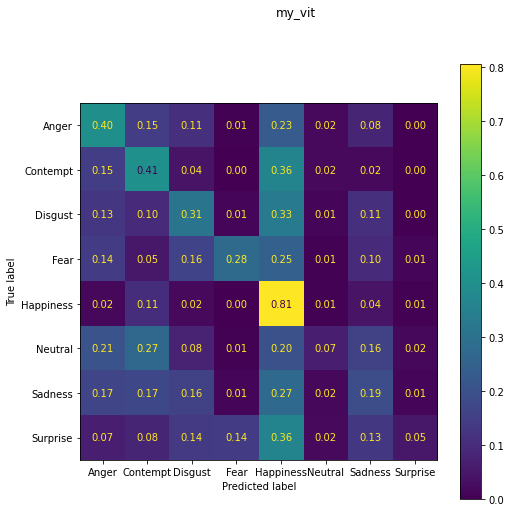

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(all_fold_test[1], [correspondance[np.array(line).argmax()] for line in predict_test["my_vit"][1]], 
                                                  labels=list(sentiments.keys()),
                                                  normalize='true'), 
                                  display_labels=list(sentiments.keys()))
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(name)
disp.plot(ax=ax, values_format=".2f")
plt.show()

In [ ]:
def extract_face(img, ld_m):
    rows, cols = img.shape[:2]

    points_normal = np.array([ld_m[0]*cols, ld_m[1]*rows])
    points = points_normal.T.astype(np.int32)
    convexh = cv2.convexHull(points)

    mask = np.zeros_like(img)
    mask = cv2.fillConvexPoly(mask, convexh, (255,255,255))

    return cv2.bitwise_and(img, mask)

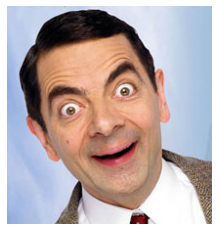

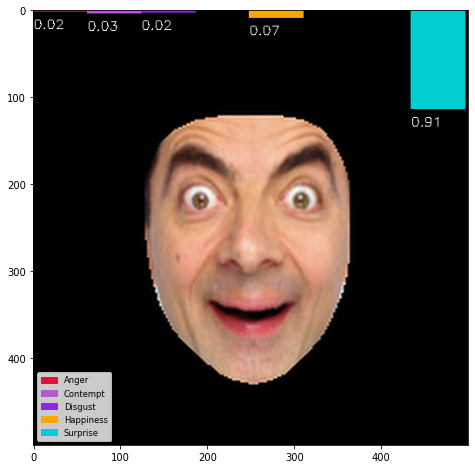

In [ ]:
img = nd.im_load("/content/drive/MyDrive/Sentiments/grimace.jpg")
# img = nd.im_load("/content/drive/MyDrive/Sentiments/triste.jpg")
nd.im_show(img)
ld.landmarks_detector(1, 0.8)
land = ld.extract_landmarks(img)
im_align = ld.align_face(img, land)
land = ld.extract_landmarks(im_align)
im_align = ld.align_face(im_align, land)

historys = nd.list_ext(path_models, [".pth"])

predict_test2 = {}

for model_name in historys:
  if model_name.split(".")[0] not in predict_test2:
    if model_name not in ['my_vit.pth', 'vit_b_16.pth']:
      dataset = transform_224(extract_face(im_align, land.T)).unsqueeze(0)
      
      L = []
      
      [train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models + model_name.split(".")[0])
      model = all_models[model_name.split(".")[0]]
      
      model.load_state_dict(torch.load(path_models + model_name))
      model.eval()
      with torch.no_grad():
        L.append(model(dataset).numpy()[0])

      predict_test2[model_name.split(".")[0]] = [max(val_accuracy), L]

predict = np.array([np.array(val[1])*val[0] for val in list(predict_test2.values())])[0].mean(axis=0)

plt.figure(figsize=(8,8))
img = nd.im_redim(extract_face(im_align, land.T), (500, 500, 3))

l,c,d = img.shape

handles = []

for i in range(8):
  color = color_rgb[color_dic[correspondance[i]]]
  if round(predict[i], 2) > 0:
    img = cv2.rectangle(img, [int(c/8)*i, 0], [int(c/8)*(i+1), int(predict[i]*l/4)], color, -1)
    img = cv2.putText(img, str(round(predict[i], 2)), [int(c/8)*i, int(predict[i]*l/4)+20], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness = 1)
    handles.append(mpatches.Patch(facecolor=[val/255 for val in color], 
                                    edgecolor=[val/255 for val in color],
                                    label=correspondance[i]))
    
plt.legend(handles=handles, fontsize='small', loc='lower left')

plt.imshow(img)
plt.show()

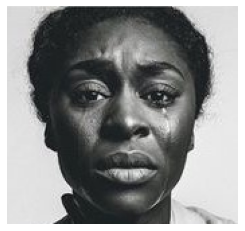

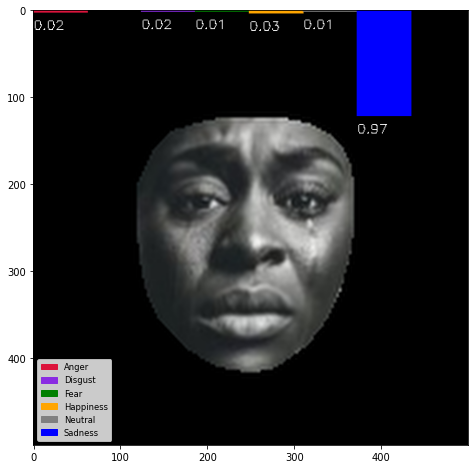

In [ ]:
img = nd.im_load("/content/drive/MyDrive/Sentiments/triste.jpg")
nd.im_show(img)
ld.landmarks_detector(1, 0.8)
land = ld.extract_landmarks(img)
im_align = ld.align_face(img, land)
land = ld.extract_landmarks(im_align)
im_align = ld.align_face(im_align, land)

historys = nd.list_ext(path_models, [".pth"])

predict_test2 = {}

for model_name in historys:
  if model_name.split(".")[0] not in predict_test2:
    if model_name not in ['my_vit.pth', 'vit_b_16.pth']:
      dataset = transform_224(extract_face(im_align, land.T)).unsqueeze(0)
      
      L = []
      
      [train_loss, val_loss, train_accuracy, val_accuracy], chang = nd.load(path_models + model_name.split(".")[0])
      model = all_models[model_name.split(".")[0]]
      
      model.load_state_dict(torch.load(path_models + model_name))
      model.eval()
      with torch.no_grad():
        L.append(model(dataset).numpy()[0])

      predict_test2[model_name.split(".")[0]] = [max(val_accuracy), L]

predict = np.array([np.array(val[1])*val[0] for val in list(predict_test2.values())])[0].mean(axis=0)

plt.figure(figsize=(8,8))
img = nd.im_redim(extract_face(im_align, land.T), (500, 500, 3))

l,c,d = img.shape

handles = []

for i in range(8):
  color = color_rgb[color_dic[correspondance[i]]]
  if round(predict[i], 2) > 0:
    img = cv2.rectangle(img, [int(c/8)*i, 0], [int(c/8)*(i+1), int(predict[i]*l/4)], color, -1)
    img = cv2.putText(img, str(round(predict[i], 2)), [int(c/8)*i, int(predict[i]*l/4)+20], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness = 1)
    handles.append(mpatches.Patch(facecolor=[val/255 for val in color], 
                                    edgecolor=[val/255 for val in color],
                                    label=correspondance[i]))
    
plt.legend(handles=handles, fontsize='small', loc='lower left')

plt.imshow(img)
plt.show()